In [1]:
library(data.table)
library(ggplot2)
library(ComplexUpset)
library(repr)


In [2]:
library(extrafont)
font_import(paths = "/Library/Fonts", prompt = FALSE)
loadfonts()
fonts()


Registering fonts with R

Scanning ttf files in /Library/Fonts ...

Extracting .afm files from .ttf files...

/System/Library/Fonts/Supplemental/Arial Unicode.ttf


 : ArialUnicodeMS already registered in fonts database. Skipping.

/Library/Fonts/FontsFree-Net-MYRIADPRO-REGULAR.ttf
 : MyriadPro-Regular already registered in fonts database. Skipping.

Found FontName for 0 fonts.

Scanning afm files in /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/library/extrafontdb/metrics

Arial Unicode MS already registered with pdfFont().

Myriad Pro already registered with pdfFont().

Arial Unicode MS already registered with postscriptFont().

Myriad Pro already registered with postscriptFont().



[1] "Arial Unicode MS" "Myriad Pro"

## Upset plot for droplet classification of hashing deconvolution methods


### Load hashing deconvolution results


In [3]:
# Load hashing deconvolution results
hash_gx38_classi <-
    fread("../data/pipeline_output/gx38/hash_classification_all.csv",
        na.strings = ""
    )

# Remove the trial ID
colnames(hash_gx38_classi) <-
    gsub("_1", "", colnames(hash_gx38_classi))

# Subset by only those cells detected by RNA
white_list_gx38 <-
    fread("../data/dataset/barcodes_gx38.tsv", header = FALSE)$V1
hash_gx38_classi <- hash_gx38_classi[Barcode %in% white_list_gx38, ]

# remove result of Solo
hash_gx38_classi <- hash_gx38_classi[, -7]
colnames(hash_gx38_classi) <-
    c(
        "Barcode",
        "DemuxEM",
        "HashedDrops",
        "HashSolo",
        "HTODemux",
        "Multiseq",
        "GMM_Demux",
        "BFF"
    )


head(hash_gx38_classi)


Barcode,DemuxEM,HashedDrops,HashSolo,HTODemux,Multiseq,GMM_Demux,BFF
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AAACCCAAGGATGAGA-1,negative,negative,doublet,negative,singlet,negative,doublet
AAACCCAAGGTACCTT-1,negative,negative,doublet,negative,negative,negative,doublet
AAACCCAAGTCATTGC-1,singlet,negative,doublet,negative,singlet,negative,doublet
AAACCCAAGTTGGAGC-1,singlet,negative,doublet,negative,singlet,negative,doublet
AAACCCACAAGGCTTT-1,negative,negative,doublet,negative,singlet,negative,doublet
AAACCCACACACAGCC-1,doublet,negative,doublet,singlet,doublet,negative,doublet


### Define a function to convert the result to a binary matrix


In [4]:
convert2binary <- function(assignment, identity) {
  # table in a long format
  assignment_new <- melt(assignment, id.vars = 1)
  assignment_new <- na.omit(assignment_new)

  # Subset to identity
  assignment_new <-
    assignment_new[assignment_new$value == identity, ]
  assignment_new <- assignment_new[, -3]

  # table in a wide format
  assignment_new <- dcast(assignment_new, Barcode ~ variable)
  assignment_new <-
    as.data.frame(lapply(assignment_new[, -1], as.numeric))

  # turn into a binary matrix
  assignment_new[!is.na(assignment_new)] <- 1
  assignment_new[is.na(assignment_new)] <- 0

  return(assignment_new)
}


In [5]:
hash_gx38_classi_new_singlet <- convert2binary(hash_gx38_classi, "singlet")
head(hash_gx38_classi_new_singlet)


Using 'variable' as value column. Use 'value.var' to override



,DemuxEM,HashedDrops,HashSolo,HTODemux,Multiseq,BFF
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,1,0
2,1,0,0,0,1,0
3,1,0,0,0,1,0
4,0,0,0,0,1,0
5,0,0,0,1,0,0
6,0,0,0,0,1,0


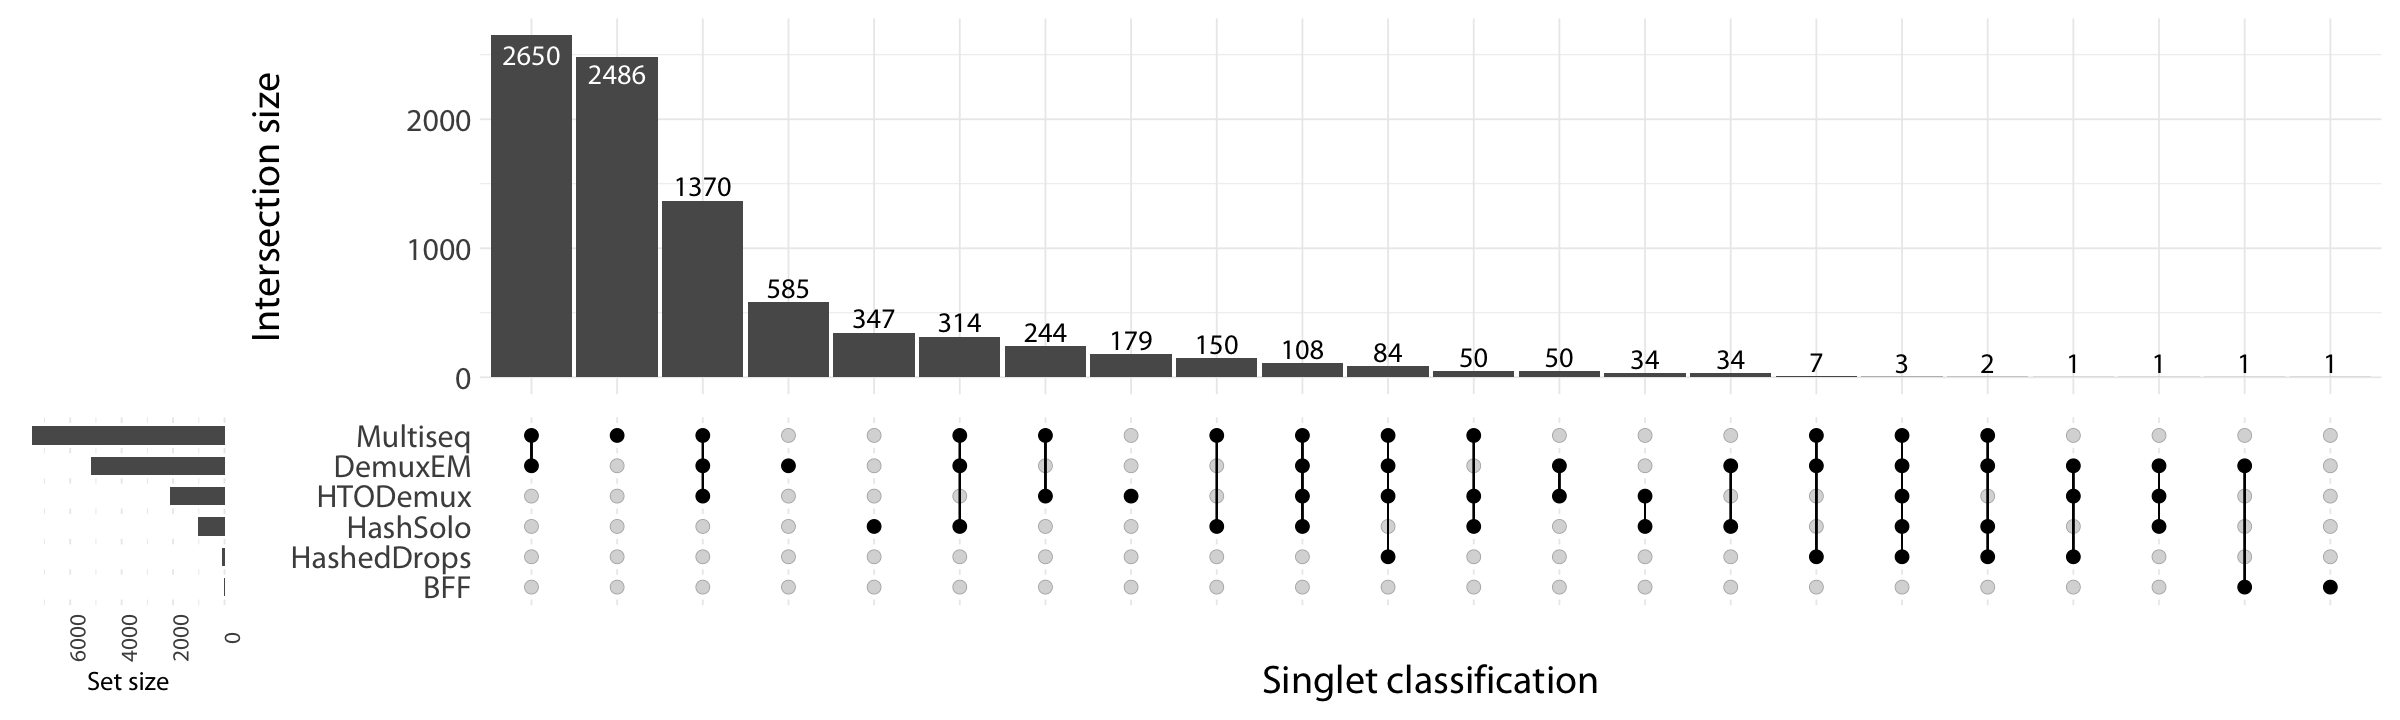

In [6]:
# Change plot size to 20 x 6
options(repr.plot.width = 20, repr.plot.height = 6)

# Ppset plot
ComplexUpset::upset(
    hash_gx38_classi_new_singlet,
    colnames(hash_gx38_classi_new_singlet),
    width_ratio = 0.1,
    height_ratio = 0.5,
    stripes = "white",
    min_degree = 1,
    name = "Singlet classification",
    set_sizes = (
        upset_set_size() + theme(
            axis.text.x = element_text(angle = 90, size = 14),
            axis.title.x = element_text(
                size =
                    16
            )
        )
    ),
    base_annotations = list(
        "Intersection size" = intersection_size(
            text = list(size = 6, family = "Myriad Pro"),
            width = 0.95,
            bar_number_threshold =
                0.9
        )
    ),
    themes = upset_default_themes(text = element_text(
        size = 24, family =
            "Myriad Pro"
    ))
)


# ggsave(
#     "s7/upset-hash-singlet-gx38.pdf",
#     width = 20,
#     height = 6,
#     dpi = 300
# )


In [7]:
ComplexUpset::upset(
       hash_gx38_classi_new_doublet,
       colnames(hash_gx38_classi_new_doublet),
       width_ratio = 0.1,
       height_ratio = 0.5,
       stripes = "white",
       min_degree = 1,
       name = "Doublet classification",
       set_sizes = (
              upset_set_size() + theme(
                     axis.text.x = element_text(angle = 90, size = 14),
                     axis.title.x = element_text(size = 16)
              )
       ),
       base_annotations = list(
              "Intersection size" = intersection_size(
                     text = list(size = 6, family = "Myriad Pro"),
                     width = 0.95,
                     bar_number_threshold = 0.9
              )
       ),
       themes = upset_default_themes(text = element_text(size = 24, family = "Myriad Pro"))
)

ggsave(
       "s7/upset-hash-doublet-gx38.pdf",
       width = 20,
       height = 6,
       dpi = 300
)


ERROR: Error in eval(expr, envir, enclos): Objekt 'hash_gx38_classi_new_doublet' nicht gefunden


## Upset plot for hashtag identification of hashing deconvolution methods


In [8]:
# Load hashing deconvolution results
hash_gx38_assign <-
    fread("../data/pipeline_output/gx38/hash_assignment_all.csv",
        na.strings = ""
    )

# Remove the trial ID
colnames(hash_gx38_assign) <- c(
    "Barcode",
    "HashSolo",
    "DemuxEM",
    "HashedDrops",
    "HTODemux",
    "Multiseq",
    "GMM_Demux",
    "BFF"
)

# Subset by only those cells detected by RNA
white_list_gx38 <-
    fread("../data/dataset/barcodes_gx38.tsv", header = FALSE)$V1
hash_gx38_assign <- hash_gx38_assign[Barcode %in% white_list_gx38, ]

# Remove TotalSeqA suffix
hash_gx38_assign$HTODemux <-
    gsub("-TotalSeqA", "", hash_gx38_assign$HTODemux)
hash_gx38_assign$Multiseq <-
    gsub("-TotalSeqA", "", hash_gx38_assign$Multiseq)
hash_gx38_assign$DemuxEM <-
    gsub("_TotalSeqA", "", hash_gx38_assign$DemuxEM)
hash_gx38_assign$HashSolo <-
    gsub("_TotalSeqA", "", hash_gx38_assign$HashSolo)
hash_gx38_assign$GMM_Demux <-
    gsub("_TotalSeqA", "", hash_gx38_assign$GMM_Demux)

# Rename HashedDrops donor
hash_gx38_assign$HashedDrops <-
    ifelse(
        hash_gx38_assign$HashedDrops != "negative",
        paste0("Hash45", hash_gx38_assign$HashedDrops),
        hash_gx38_assign$HashedDrops
    )

head(hash_gx38_assign)


Barcode,HashSolo,DemuxEM,HashedDrops,HTODemux,Multiseq,GMM_Demux,BFF
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AAACCCAAGGATGAGA-1,doublet,negative,negative,negative,Hash454,negative,doublet
AAACCCAAGGTACCTT-1,doublet,negative,negative,negative,negative,negative,doublet
AAACCCAAGTCATTGC-1,doublet,Hash454,negative,negative,Hash454,negative,doublet
AAACCCAAGTTGGAGC-1,doublet,Hash453,negative,negative,Hash453,negative,doublet
AAACCCACAAGGCTTT-1,doublet,negative,negative,negative,Hash453,negative,doublet
AAACCCACACACAGCC-1,doublet,doublet,negative,Hash453,doublet,negative,doublet


In [9]:
# Change plot size to 12 x 8
options(repr.plot.width = 10, repr.plot.height = 6)

draw_upsetplot <- function(hashtag) {
  # convert to binary matrix
  hashtag_input <- convert2binary(hash_gx38_assign, hashtag)
  ComplexUpset::upset(
    hashtag_input,
    colnames(hashtag_input),
    width_ratio = 0.1,
    height_ratio = 0.5,
    stripes = "white",
    min_degree = 1,
    name = paste0(
      "Identification of hashtag ",
      gsub("Hash", "", hashtag)
    ),
    set_sizes = (
      upset_set_size() +
        theme(
          axis.text.x = element_text(
            angle = 90,
            size = 14
          ),
          axis.title.x = element_text(size = 16)
        )
    ),
    base_annotations = list(
      "Intersection size" = intersection_size(
        text = list(size = 6, family = "Myriad Pro"),
        width = 0.95,
        bar_number_threshold = 0.9
      )
    ),
    themes = upset_default_themes(text = element_text(size = 24, family = "Myriad Pro"))
  )

  # ggsave(paste0("s7/upset-hashing-gx38-", hashtag, ".pdf"),
  #   width = 10, height = 6, dpi = 300
  # )
}


Using 'variable' as value column. Use 'value.var' to override



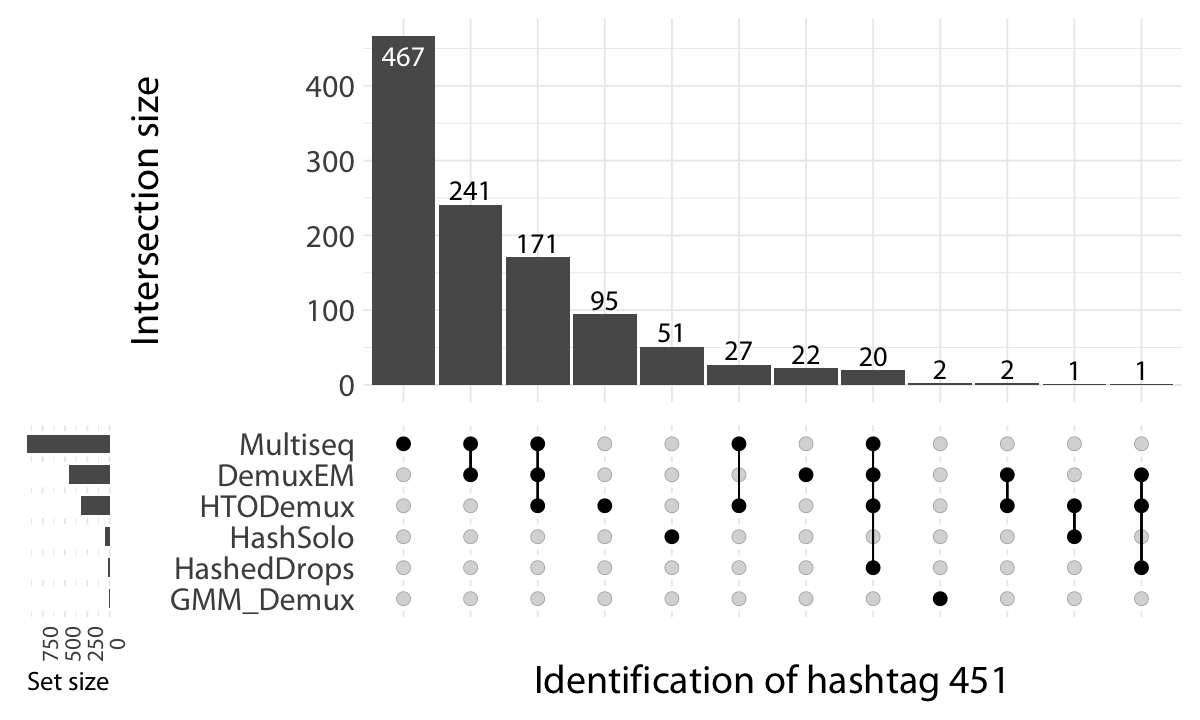

In [10]:
draw_upsetplot("Hash451")


Using 'variable' as value column. Use 'value.var' to override



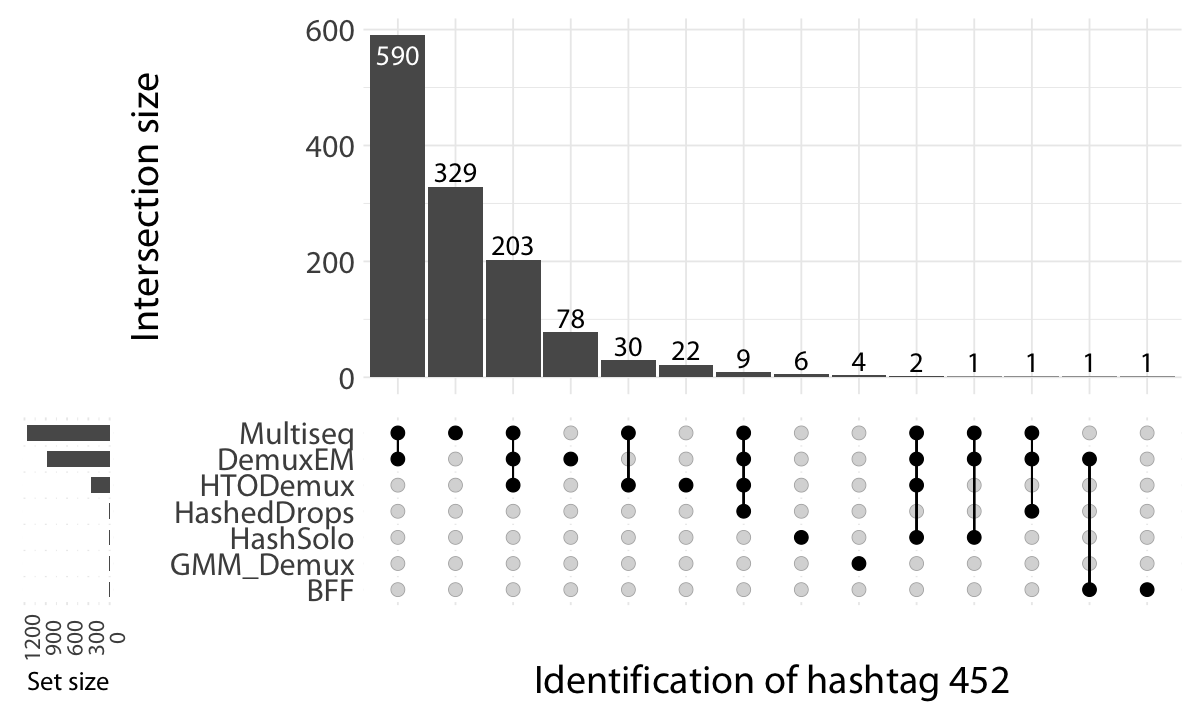

In [11]:
draw_upsetplot("Hash452")


Using 'variable' as value column. Use 'value.var' to override



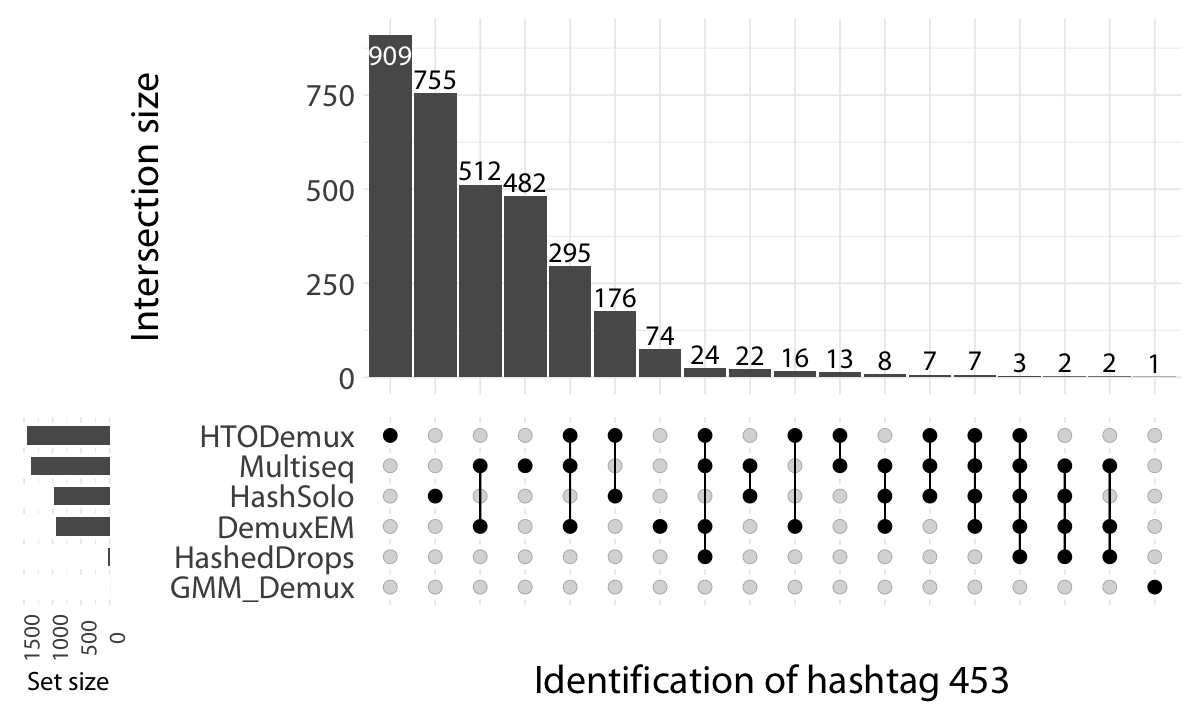

In [12]:
draw_upsetplot("Hash453")


Using 'variable' as value column. Use 'value.var' to override



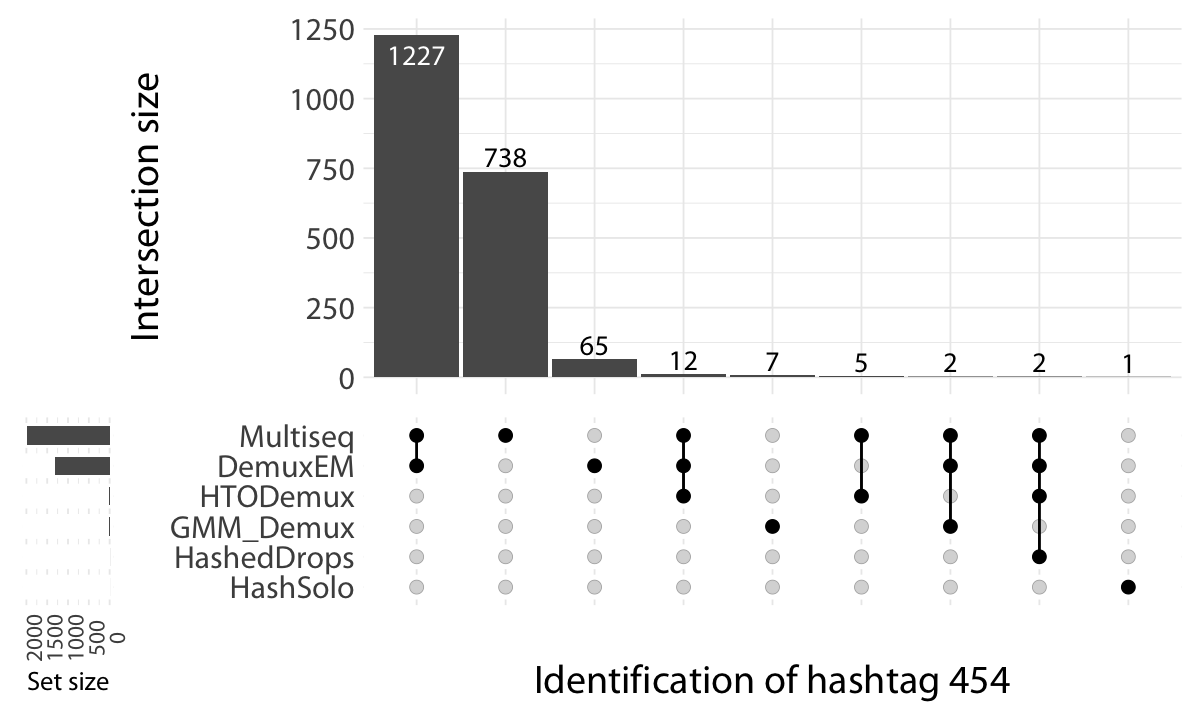

In [13]:
draw_upsetplot("Hash454")


Using 'variable' as value column. Use 'value.var' to override



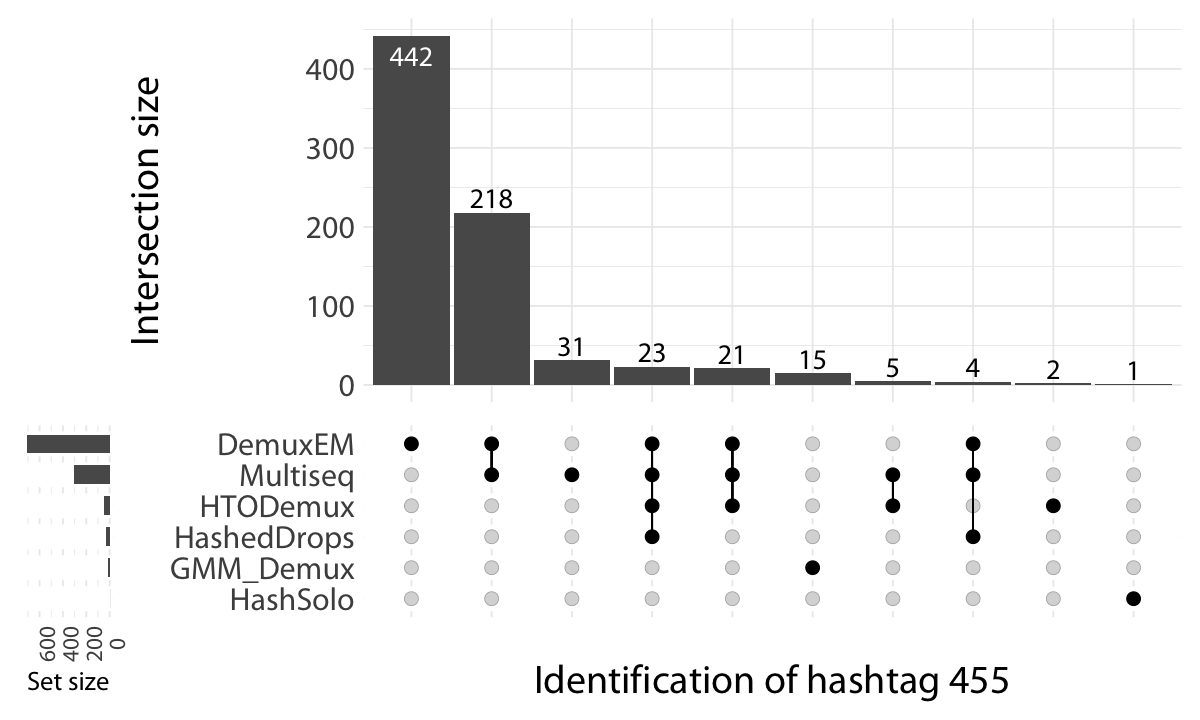

In [14]:
draw_upsetplot("Hash455")


Using 'variable' as value column. Use 'value.var' to override



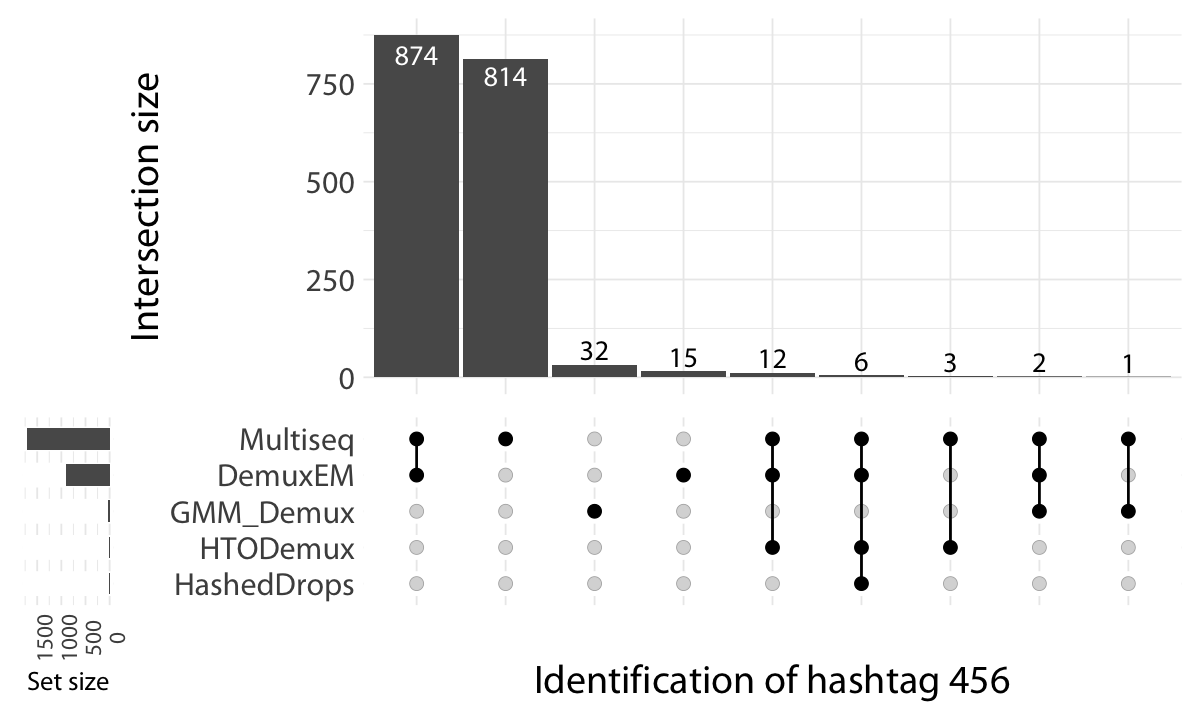

In [15]:
draw_upsetplot("Hash456")
